In [14]:
import numpy as np
import pandas as pd
import cmath
%matplotlib widget
import matplotlib.pyplot as plt

### Импорт данных

In [15]:
pin_diode = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\pin_diode.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
screen = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\screen.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
kz = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\kz.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_0 = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx0.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_2 = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx2.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_8 = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx8.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])
xx_nn = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\waveguide\\xx_no_number.s1p',
                          sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                          names=['Frequency', 'ReS11', 'ImS11'])

In [16]:
df_list = [pin_diode, screen, kz, xx_0, xx_2, xx_8, xx_nn]

for df in df_list:
    df['S11'] = df['ReS11'] + 1j*df['ImS11']

del df_list
del df

In [17]:

pin_diode = pin_diode.drop(['ReS11', 'ImS11'], axis=1)
screen = screen.drop(['ReS11', 'ImS11'], axis=1)
kz = kz.drop(['ReS11', 'ImS11'], axis=1)
xx_0 = xx_0.drop(['ReS11', 'ImS11'], axis=1)
xx_2 = xx_2.drop(['ReS11', 'ImS11'], axis=1)
xx_8 = xx_8.drop(['ReS11', 'ImS11'], axis=1)
xx_nn = xx_nn.drop(['ReS11', 'ImS11'], axis=1)

In [18]:
df_list = [pin_diode, kz, xx_0, xx_2, xx_8, xx_nn]

for df in df_list:
    df['S11_norm'] = -df['S11'] / screen['S11']

del df_list
del df

### Построение графиков

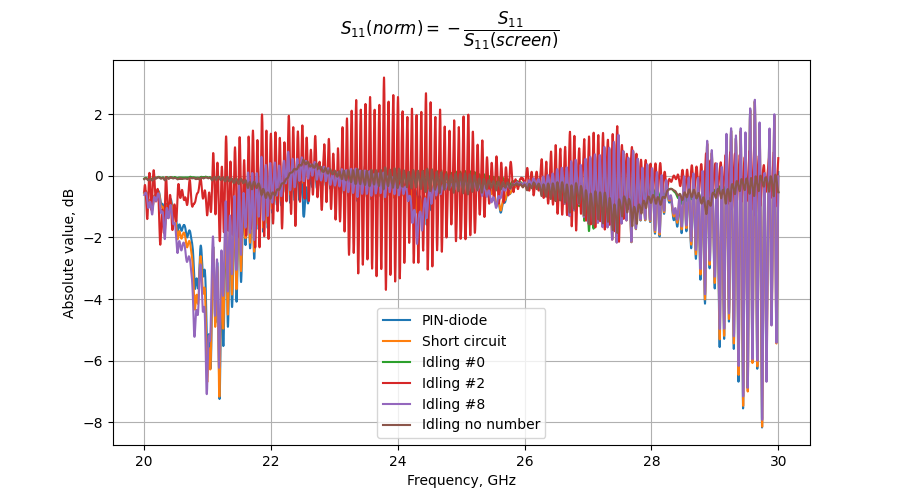

In [19]:
fig1 = plt.figure(figsize=(9,5))

ax_1 = fig1.add_subplot(111)
ax_1.plot(pin_diode['Frequency']*1e-9, 20*np.log10(pin_diode['S11_norm'].apply(abs)), label=r'PIN-diode')
ax_1.plot(kz['Frequency']*1e-9, 20*np.log10(kz['S11_norm'].apply(abs)), label=r'Short circuit')
ax_1.plot(xx_0['Frequency']*1e-9, 20*np.log10(xx_0['S11_norm'].apply(abs)), label=r'Idling #0')
ax_1.plot(xx_2['Frequency']*1e-9, 20*np.log10(xx_2['S11_norm'].apply(abs)), label=r'Idling #2')
ax_1.plot(xx_8['Frequency']*1e-9, 20*np.log10(xx_8['S11_norm'].apply(abs)), label=r'Idling #8')
ax_1.plot(xx_nn['Frequency']*1e-9, 20*np.log10(xx_nn['S11_norm'].apply(abs)), label=r'Idling no number')
ax_1.set_xlabel(r'Frequency, GHz')
ax_1.set_ylabel('Absolute value, dB')
ax_1.legend()
ax_1.grid()


fig1.suptitle(r'$S_{11}(norm) = -\dfrac{S_{11}}{S_{11}(screen)}$')
plt.show()

In [ ]:
fig1 = plt.figure(figsize=(9,5))

ax_1 = fig1.add_subplot(111)
ax_1.plot(pin_diode['Frequency']*1e-9, 20*np.log10(pin_diode['S11_norm'].apply(abs)), label=r'PIN-diode')
ax_1.plot(kz['Frequency']*1e-9, 20*np.log10(kz['S11_norm'].apply(abs)), label=r'Short circuit')
ax_1.plot(xx_0['Frequency']*1e-9, 20*np.log10(xx_0['S11_norm'].apply(abs)), label=r'Idling #0')
ax_1.plot(xx_2['Frequency']*1e-9, 20*np.log10(xx_2['S11_norm'].apply(abs)), label=r'Idling #2')
ax_1.plot(xx_8['Frequency']*1e-9, 20*np.log10(xx_8['S11_norm'].apply(abs)), label=r'Idling #8')
ax_1.plot(xx_nn['Frequency']*1e-9, 20*np.log10(xx_nn['S11_norm'].apply(abs)), label=r'Idling no number')
ax_1.set_xlabel(r'Frequency, GHz')
ax_1.set_ylabel('Absolute value, dB')
ax_1.legend()
ax_1.grid()


fig1.suptitle(r'$S_{11}(norm) = -\dfrac{S_{11}}{S_{11}(screen)}$')
plt.show()